In [1]:
import pandas as pd

In [3]:
data = pd.read_csv('train.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV


In [7]:
data_train, data_test, y_train, y_test = train_test_split(data.drop(columns='SalePrice'), data['SalePrice'], test_size=0.30, random_state=42)

In [8]:
#Находим категориальные признаки
categorials = list(data.dtypes[data.dtypes == object].index)
categorials_nunique = data_train[categorials].nunique()

#закодируем пропущенные значений строкой
data[categorials] = data[categorials].fillna('nan')

# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(data_train[categorials], columns=categorials)
dummy_test = pd.get_dummies(data_test[categorials], columns=categorials)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]

#отфильтруем непрерывные признаки
integer = [f for f in data if f not in (categorials + ['ID', 'SalePrice'])]

# Заменяем пропуски на последнее валидное значение
X_train = pd.concat([data_train[integer].fillna(method='ffill'), dummy_train], axis=1)

X_test = pd.concat([data_test[integer].fillna(method='ffill'), dummy_test], axis=1)

In [12]:
# для RandomForestRegressor проверим качество с крос-валидацией 
kf = KFold(n_splits=10, random_state=None)
model = RandomForestRegressor()
 
result = cross_val_score(model , X_train, y_train, cv = kf)
print('Avg accuracy : {}'.format(result))


Avg accuracy : [0.81986782 0.90497325 0.65543873 0.70891481 0.83659583 0.87850217
 0.83402362 0.90477643 0.82674914 0.88739917]


In [13]:
#Подберем гипер-параметры
from sklearn.model_selection import GridSearchCV
rfr=RandomForestRegressor()
k_fold_cv = 10 
grid_params = {
 'max_depth': [None, 2,3,5],
 'n_estimators' : [10,50,100],
 'max_features' : ['auto', 'log2', 'sqrt'],
 'bootstrap' : [True, False]
 }
grid = GridSearchCV(rfr, param_grid=grid_params, cv=k_fold_cv, 
 n_jobs = 1, verbose = 0, return_train_score=True)
grid.fit(X_train, y_train)
print('Best hyper parameter:', grid.best_params_)


Best hyper parameter: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}


In [14]:
clf_rf = grid.best_estimator_

In [15]:

kf = KFold(n_splits=10, random_state=None)
 
result = cross_val_score(clf_rf , X_train, y_train, cv = kf)
print('Avg accuracy : {}'.format(result))

Avg accuracy : [0.80543552 0.90131988 0.74579193 0.7625135  0.80485165 0.87401281
 0.82445213 0.86770501 0.89310479 0.89584941]


In [16]:
clf_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt')

In [26]:
clf_rf.score(X_train, y_train)

0.9999999798081092

In [17]:
clf_rf.score(X_test, y_test)

0.8844623248508713

In [18]:
# оценим важность признаков
imp = pd.Series(clf_rf.feature_importances_)
imp.index = pd.Series(X_train.columns)

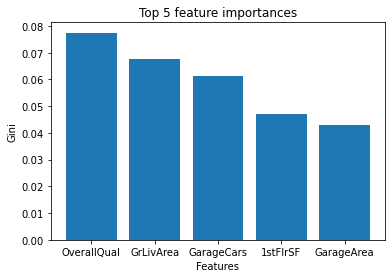

In [19]:
plt.title('Top 5 feature importances')
plt.xlabel('Features')
plt.ylabel('Gini')
plt.bar(imp.sort_values(ascending=False).head().index, imp.sort_values(ascending=False).head())
plt.show()

In [20]:
# далее обучим стэкинг нескольких моделуй регрессии

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV


In [21]:
Regressor = StackingRegressor(
    [
        ('LinearRegression', LinearRegression()),
        ('KNeighborsRegressor', KNeighborsRegressor()),
        ('DecisionTree', DecisionTreeRegressor()),
        ('BayesianRidge',BayesianRidge())
    ], RidgeCV(), cv=10)

In [22]:
Regressor.fit(X_train, y_train)

StackingRegressor(cv=10,
                  estimators=[('LinearRegression', LinearRegression()),
                              ('KNeighborsRegressor', KNeighborsRegressor()),
                              ('DecisionTree', DecisionTreeRegressor()),
                              ('BayesianRidge', BayesianRidge())],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [23]:
print(f'Score on train data {Regressor.score(X_train, y_train)}')
print(f'Score on test data {Regressor.score(X_test, y_test)}')

for i in Regressor.named_estimators:
    print(f'Score on train data with model {i} {Regressor.named_estimators_[i].score(X_train, y_train)}')
    print(f'Score on test data with model {i} {Regressor.named_estimators_[i].score(X_test, y_test)}')


Score on train data 0.9357974788397697
Score on test data 0.8687302340846265
Score on train data with model LinearRegression 0.9222314864481874
Score on test data with model LinearRegression 0.854225029472359
Score on train data with model KNeighborsRegressor 0.7376959509739042
Score on test data with model KNeighborsRegressor 0.6790620152417928
Score on train data with model DecisionTree 1.0
Score on test data with model DecisionTree 0.7397418574691963
Score on train data with model BayesianRidge 0.7359773607781728
Score on test data with model BayesianRidge 0.7889093680813482
